# Predicting Diabetes with Logistic Regression 

Here, we use the diabetes dataset to illustrate logistic regression and the model performance evaluation.

You may also run it on Google Colab with this link: [demo_sklearn_classifier.ipynb](https://colab.research.google.com/github/huangyh09/nnwrapper/blob/main/examples/demo_sklearn_classifier.ipynb)

## Import Libraries and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 
             'bmi', 'pedigree', 'age', 'diabetes']

# load dataset
github_path = 'https://raw.githubusercontent.com/huangyh09/foundation-data-science/'
dat_dir = github_path + 'main/w10-classification/'

# dat_dir = './'

pima = pd.read_csv(dat_dir + "diabetes.csv", skiprows=1, names=col_names)

In [3]:
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pima.shape

(768, 9)

## Selecting Feature and splitting data

For Features considering all the columns except label, as it is our Target.

In [5]:
feature_cols = ['pregnant', 'glucose', 'bp','skin', 
                'insulin', 'bmi', 'pedigree','age']

X = pima[feature_cols] # Features
y = pima.diabetes      # Target variable

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [7]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(576, 8)

(576,)

(192, 8)

(192,)

## Train the Model: a first try with all the variables

Here, we use `sklearn` as for its wide utility functions. More details on logistic regression: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [8]:
# in sklearn, it will add intercept by default

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [9]:
# same fitted model parameters as statsmodels

clf.coef_, clf.intercept_

(array([[ 0.08617362,  0.0331269 , -0.01117628,  0.00604808, -0.00100752,
          0.08797458,  0.80034312,  0.02221368]]),
 array([-8.37792905]))

In [10]:
# prediction on test set

P_hat_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (P_hat_prob >= 0.5).astype(int)

### Model Evaluation 

In [11]:
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

cnf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                         colnames=['Predicted'])
cnf_matrix

Predicted,0,1
Actual,,
0,117,13
1,26,36


In [12]:
# think how accuracy is defined
# we can use (TN + TP) / (TN + TP + FN + FP)
# we can also directly compare the proportion of correctness
# we can also use metrics.accuracy_score

# accuracyScore = metrics.accuracy_score(y_test, y_pred)

print('Accuracy: %.4f' %(np.mean(y_test == y_pred)))

Accuracy: 0.7969


### ROC curve and AUC

* `sklearn.metrics` module has many useful assessment functions

In [13]:
import numpy as np
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, P_hat_prob)
roc_auc = metrics.roc_auc_score(y_test, P_hat_prob)

In [14]:
roc_auc

0.8593052109181142

In [15]:
_query_threshold1 = 0.3
idx1 = np.argmin(np.abs(thresholds - _query_threshold1))
_fpr1, _tpr1, _threshold1 = fpr[idx1], tpr[idx1], thresholds[idx1]

_query_threshold2 = 0.5
idx2 = np.argmin(np.abs(thresholds - _query_threshold2))
_fpr2, _tpr2, _threshold2 = fpr[idx2], tpr[idx2], thresholds[idx2]

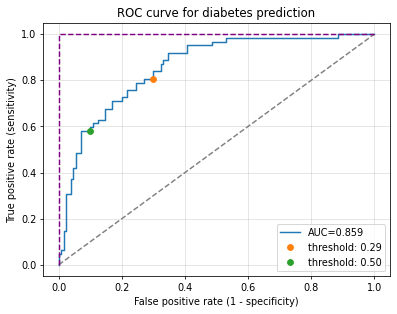

In [16]:
fig = plt.figure(figsize=(6.4, 4.8), dpi=70)
plt.plot(fpr, tpr, label='AUC=%.3f' %(roc_auc))

plt.plot(_fpr1, _tpr1, 'o', label='threshold: %.2f' %(_threshold1))
plt.plot(_fpr2, _tpr2, 'o', label='threshold: %.2f' %(_threshold2))

plt.plot([0, 1], [0, 1], '--', color='grey')
plt.plot([0, 0, 1], [0, 1, 1], '--', color='purple')

plt.grid(alpha=0.4)

plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")
plt.title("ROC curve for diabetes prediction")
plt.legend()
plt.show()

## Cross-validation

* Sklearn has very handy build-in functions, e.g., `cross_val_predict`. 
* **Note**, we may want to keep the same fold split via `StratifiedKFold`
* More intro on cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html 

In [17]:
feature_cols = ['pregnant', 'glucose', 'bp','skin', 
                'insulin', 'bmi', 'pedigree','age']

X = pima[feature_cols] # Features
y = pima.diabetes      # Target variable

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

clf = LogisticRegression(max_iter=300)

# by default, cross_val_predict won't shuffle; to shuffle and keep the same split
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

y_pred_proba_cv = cross_val_predict(clf, X, y, cv=skf, method='predict_proba')
P_hat_prob_cv = y_pred_proba_cv[:, 1]

In [19]:
fpr_cv, tpr_cv, thresholds_cv = metrics.roc_curve(y, P_hat_prob_cv)
roc_auc_cv = metrics.roc_auc_score(y, P_hat_prob_cv)
roc_auc_cv

0.8278731343283583

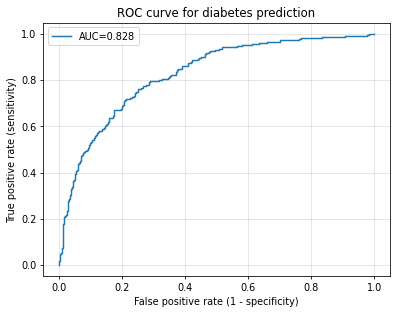

In [20]:
fig = plt.figure(figsize=(6.4, 4.8), dpi=70)
plt.plot(fpr_cv, tpr_cv, label='AUC=%.3f' %(roc_auc_cv))
plt.grid(alpha=0.4)
plt.xlabel("False positive rate (1 - specificity)")
plt.ylabel("True positive rate (sensitivity)")
plt.title("ROC curve for diabetes prediction")
plt.legend()
plt.show()